In [1]:
import tensorflow as tf
from model import make_simple_cnn, make_resnet
from cleverhans.utils_tf import tf_model_load, model_eval
from utilities import *

tf.reset_default_graph()
model = make_simple_cnn()

# make sure the target model is working
sess = tf.Session()
tf_model_load(sess, file_path='./pretrained/model')

x = tf.placeholder(tf.float32,[None,32,32,3])
y = tf.placeholder(tf.float32,[None,10])
from utilities import validate_model
(x_train,y_train), (x_test,y_test) = data_cifar10()
validate_model(sess,x,y,model)
x_filtered,y_filtered = filter_data(sess, x, y, model, x_test, y_test, target = None)

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from ./pretrained/model


Using TensorFlow backend.


base accuracy of the target model on normal images: 0.8341


In [2]:
print(x_filtered.shape)

(1280, 32, 32, 3)


In [3]:
target = None
adv_imgs = attack_classifier(sess, x, y, model, x_filtered, y_filtered, attack_method = "basic_iterative", target = target)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [4]:
print(adv_imgs.shape)

(1280, 32, 32, 3)


In [5]:
params = {'eps':8/255,
          'eps_iter':1/255,
          'nb_iter': 10,
          'clip_min': 0.,
          'clip_max': 1.
}
steps = attack_with_step_recorded(sess,x,y,model,x_filtered,y_filtered, params, batch_size = 128)

In [8]:
dist = []
for i in range(len(steps)):
    dist.append(np.absolute(steps[i]-steps[-1]))

In [32]:
count = []
for i in range(len(steps)):
    c = 0
    for each in dist[i].flatten():
        if each > 8/255:
            c+= 1
    count.append(c)
print(count)

[4013, 633, 0, 0, 0, 0, 0, 0, 0, 0]


In [35]:
np.array(count)/(3*32*32 * 1280 )

array([0.00102056, 0.00016098, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [5]:
from utilities import model_eval_adv
model_eval_adv(sess,x,y,model,adv_imgs,y_filtered, target = target)

Success rate of non target attacks: 0.9867187



In [35]:
i_th = 1
print("original prob:",np.argmax(predict(sess,x,model,np.array(x_test))[i_th]))
print("adv prob:",np.argmax(predict(sess,x,model,np.array(adv_imgs))[i_th]))
num_sample = 12800
samples = []
for i in range(num_sample):
    samples.append(np.random.normal(adv_imgs[i_th], x_test[i_th]))
probs = predict(sess,x,model,np.array(samples))
indices = np.argmax(probs, axis = 1)
percent = np.array([0 for _ in range(10)])
for each in indices:
    percent[each] += 1
percent = percent/num_sample
print(percent)
print(np.flip(np.argsort(percent), axis = 0))
print(np.flip(np.sort(percent), axis= 0))

original prob: 8
adv prob: 1
[6.02343750e-02 4.81250000e-01 3.58593750e-02 3.90625000e-04
 3.18750000e-02 0.00000000e+00 8.67968750e-02 6.25000000e-04
 2.35156250e-02 2.79453125e-01]
[1 9 6 0 2 4 8 7 3 5]
[4.81250000e-01 2.79453125e-01 8.67968750e-02 6.02343750e-02
 3.58593750e-02 3.18750000e-02 2.35156250e-02 6.25000000e-04
 3.90625000e-04 0.00000000e+00]


In [26]:
from utilities import backtracking
batch_size = 128
y_ = tf.constant(np.repeat(np.eye(10)[target:target+1], batch_size, axis = 0))
params = {'eps':8/255,
          'eps_iter':1/255/10,
          'nb_iter': 100,
          'y':y_,
          'clip_min': 0.,
          'clip_max': 1.
}
imgs = backtracking(sess, x, y, model, adv_imgs, y_filtered, params, batch_size = batch_size)
model_eval(sess, x, y_, model.get_probs(x), X_test=imgs, Y_test=y_filtered, args={"batch_size":batch_size})

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [ ]:
predict(sess,x,model,x_filtered)

In [63]:
print(np.mean(np.mean(np.absolute(x_filtered - imgs), axis = 0)))

0.018957047


In [64]:
print(np.mean(np.mean(np.absolute(x_filtered - adv_imgs), axis = 0)))

0.002217048


In [65]:
print(np.mean(np.mean(np.absolute(adv_imgs - imgs), axis = 0)))

0.020316975


In [6]:
from utilities import backtracking, backtracking_with_gaussian
batch_size = 128
params = {'eps':8/255,
          'eps_iter':1/255,
          'nb_iter': 10,
          'y':y,
          'clip_min': 0.,
          'clip_max': 1.
}
y_probs = np.zeros([adv_imgs.shape[0],10])
idx = np.argmax(predict(sess,x,model,adv_imgs), axis = 1)
for i in range(y_probs.shape[0]):
    y_probs[i][idx[i]] = 1

imgs = adv_imgs
#imgs = np.clip(adv_imgs + ((np.random.uniform(size = (1280, 32, 32, 3)) >= 0.5) - 0.5) * 1 / 255 * 4, a_min = 0, a_max = 1)
print("y_probs before:",model_eval(sess, x, y, model.get_probs(x), X_test=imgs, Y_test=y_probs, args={"batch_size":batch_size}))
imgs = backtracking_with_gaussian(sess, x, y, model, imgs, y_probs, params, batch_size = batch_size)

print("recovery_rate:",model_eval(sess, x, y, model.get_probs(x), X_test=imgs, Y_test=y_filtered, args={"batch_size":batch_size}))
print("y_probs:",model_eval(sess, x, y, model.get_probs(x), X_test=imgs, Y_test=y_probs, args={"batch_size":batch_size}))

y_probs before: 1.0
recovery_rate: 0.17421875
y_probs: 0.04453125


In [10]:
y_probs = np.zeros([adv_imgs.shape[0],10])
idx = np.argmax(predict(sess,x,model,adv_imgs), axis = 1)
for i in range(y_probs.shape[0]):
    y_probs[i][idx[i]] = 1
#imgs = adv_imgs + ((np.random.normal(size = (1280, 32, 32, 3)) >= 0.5) - 0.5) * 1/255 * 2
import scipy
imgs = scipy.ndimage.filters.gaussian_filter(adv_imgs, sigma=0.5)
model_eval(sess, x, y, model.get_probs(x), X_test=imgs, Y_test=y_filtered, args={"batch_size":batch_size})

0.03359375

In [7]:
import matplotlib.pyplot as plt
plt.imshow(adv_imgs[0])
plt.figure()
plt.imshow(imgs[0])

In [20]:
y_probs = np.zeros([adv_imgs.shape[0],10])
idx = np.argmax(predict(sess,x,model,adv_imgs), axis = 1)
for i in range(y_probs.shape[0]):
    y_probs[i][idx[i]] = 1
imgs = adv_imgs + ((np.random.normal(size = (1280, 32, 32, 3)) >= 0.5) - 0.5) * 1/255 * 2
imgs = scipy.ndimage.filters.gaussian_filter(adv_imgs, sigma=0.5)
model_eval(sess, x, y, model.get_probs(x), X_test=imgs, Y_test=y_probs, args={"batch_size":batch_size})

0.959375

In [19]:
imgs = x_filtered + ((np.random.normal(size = (1280, 32, 32, 3)) >= 0.5) - 0.5) * 1/255 * 2
imgs = scipy.ndimage.filters.gaussian_filter(x_filtered, sigma=0.5)
model_eval(sess, x, y, model.get_probs(x), X_test=imgs, Y_test=y_filtered, args={"batch_size":batch_size})

0.91796875

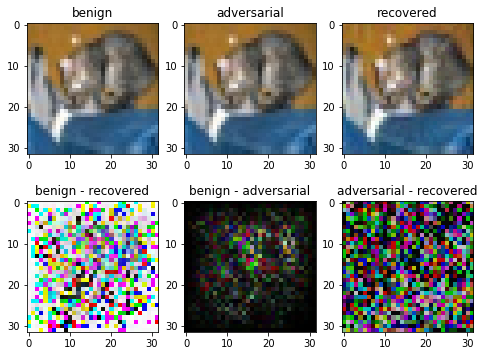

In [138]:
i_th = 1
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8, 6))
axis = fig.add_subplot(2, 3, 1)
axis.set_title("benign")
plt.imshow(x_filtered[i_th])
axis = fig.add_subplot(2, 3, 2)
axis.set_title("adversarial")
plt.imshow(adv_imgs[i_th])
axis = fig.add_subplot(2, 3, 3)
axis.set_title("recovered")
plt.imshow(imgs[i_th])
axis = fig.add_subplot(2, 3, 4)
axis.set_title("benign - recovered")
plt.imshow(255 * np.absolute(x_filtered[i_th] - imgs[i_th]))
axis = fig.add_subplot(2, 3, 5)
axis.set_title("benign - adversarial")
plt.imshow(255 * np.absolute(x_filtered[i_th] - adv_imgs[i_th]))
axis = fig.add_subplot(2, 3, 6)
axis.set_title("adversarial - recovered")
plt.imshow(225 * np.absolute(adv_imgs[i_th] - imgs[i_th]))
plt.show()

(array([1.146234e+06, 8.951220e+05, 1.513069e+06, 3.722170e+05,
        4.367000e+03, 8.590000e+02, 2.100000e+02, 5.900000e+01,
        1.300000e+01, 1.000000e+01]),
 array([0.        , 0.01038332, 0.02076665, 0.03114997, 0.0415333 ,
        0.05191662, 0.06229995, 0.07268327, 0.08306659, 0.09344992,
        0.10383324]),
 <a list of 10 Patch objects>)

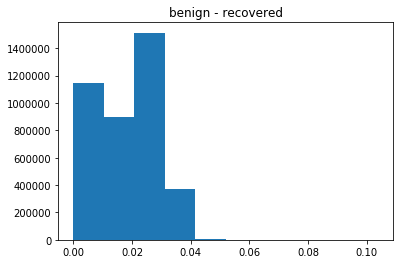

In [139]:
plt.title("benign - recovered")
plt.hist(np.absolute(x_filtered - imgs).flatten())

(array([ 379465.,   15985.,  709632.,    8409.,  657378.,   11863.,
           5140.,  618800.,   64419., 1461069.]),
 array([0.        , 0.00313726, 0.00627452, 0.00941177, 0.01254903,
        0.01568629, 0.01882355, 0.0219608 , 0.02509806, 0.02823532,
        0.03137258]),
 <a list of 10 Patch objects>)

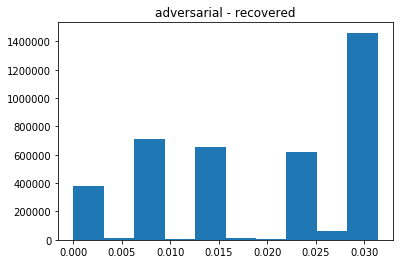

In [140]:
plt.title("adversarial - recovered")
plt.hist(np.absolute(adv_imgs - imgs).flatten())

(array([3.804138e+06, 1.083710e+05, 1.552200e+04, 3.155000e+03,
        6.940000e+02, 1.880000e+02, 6.600000e+01, 1.900000e+01,
        5.000000e+00, 2.000000e+00]),
 array([0.        , 0.01352058, 0.02704116, 0.04056174, 0.05408232,
        0.0676029 , 0.08112347, 0.09464405, 0.10816463, 0.12168521,
        0.13520579]),
 <a list of 10 Patch objects>)

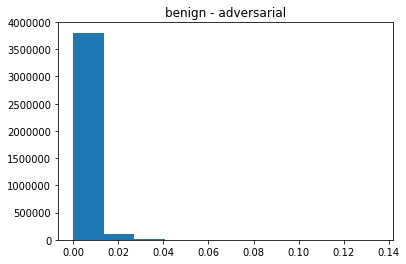

In [141]:
plt.title("benign - adversarial")
plt.hist(np.absolute(x_filtered - adv_imgs).flatten())